In [18]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load the VGG16 model, pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False)

In [3]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

In [4]:
# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# Add a logistic layer for binary classification
predictions = Dense(1, activation='sigmoid')(x)

In [5]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [6]:
# Freeze the convolutional layers of the VGG16 model
for layer in base_model.layers:
    layer.trainable = False

In [7]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
train_dir = 'dataset/train'
validation_dir = 'dataset/test'

In [9]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [10]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory( validation_dir,  batch_size = 20, class_mode = 'binary', target_size = (224, 224))

Found 6452 images belonging to 2 classes.
Found 1540 images belonging to 2 classes.


In [11]:
# Train the model on new data for a few epochs
history1 = model.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
323/323 [==============================] - 600s 2s/step - loss: 0.1264 - accuracy: 0.9626 - val_loss: 0.0196 - val_accuracy: 0.9974
Epoch 2/5
323/323 [==============================] - 607s 2s/step - loss: 0.0413 - accuracy: 0.9848 - val_loss: 0.0123 - val_accuracy: 0.9974
Epoch 3/5
323/323 [==============================] - 599s 2s/step - loss: 0.0297 - accuracy: 0.9895 - val_loss: 0.0126 - val_accuracy: 0.9955
Epoch 4/5
323/323 [==============================] - 600s 2s/step - loss: 0.0242 - accuracy: 0.9912 - val_loss: 0.0035 - val_accuracy: 0.9994
Epoch 5/5
323/323 [==============================] - 600s 2s/step - loss: 0.0215 - accuracy: 0.9927 - val_loss: 0.0021 - val_accuracy: 0.9994


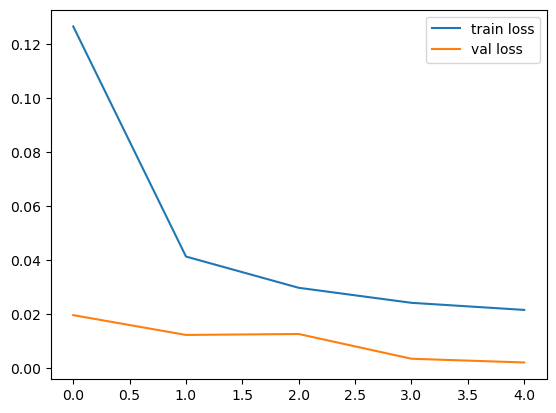

<Figure size 640x480 with 0 Axes>

In [14]:
# loss
plt.plot(history1.history['loss'], label='train loss')
plt.plot(history1.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

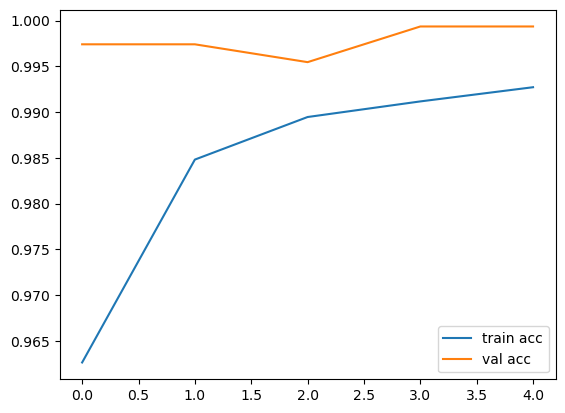

<Figure size 640x480 with 0 Axes>

In [16]:
# accuracies
plt.plot(history1.history['accuracy'], label='train acc')
plt.plot(history1.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

77/77 [==============================] - 112s 1s/step


<Figure size 800x600 with 0 Axes>

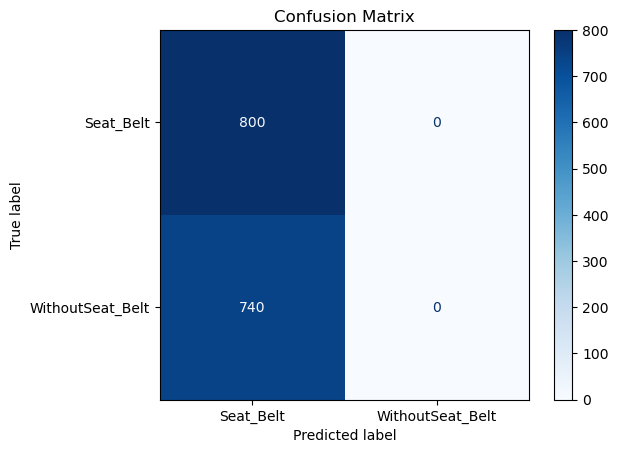

In [19]:
#confusion matrix
y_true = validation_generator.classes

y_pred = model.predict(validation_generator)
predicted_classes = np.argmax(y_pred, axis=1)

from sklearn import metrics
cm = metrics.confusion_matrix(y_true, predicted_classes)
plt.figure(figsize=(8, 6))
metrics.ConfusionMatrixDisplay(cm, display_labels=['Seat_Belt', 'WithoutSeat_Belt']).plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [20]:
#classification report
class_labels = list(validation_generator.class_indices.keys())
report = metrics.classification_report(y_true, predicted_classes, target_names=class_labels, zero_division=1)
print(report)

              precision    recall  f1-score   support

  noSeatbelt       0.52      1.00      0.68       800
    seatbelt       1.00      0.00      0.00       740

    accuracy                           0.52      1540
   macro avg       0.76      0.50      0.34      1540
weighted avg       0.75      0.52      0.36      1540



In [21]:
# Fine-tune the model by unfreezing the top layers of the VGG16 model
for layer in model.layers[:15]:
    layer.trainable = False
for layer in model.layers[15:]:
    layer.trainable = True

In [22]:
# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
# Continue training the model for a few more epochs
history2 = model.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
323/323 [==============================] - 738s 2s/step - loss: 0.1519 - accuracy: 0.9592 - val_loss: 0.0083 - val_accuracy: 0.9987
Epoch 2/5
323/323 [==============================] - 740s 2s/step - loss: 0.0209 - accuracy: 0.9927 - val_loss: 0.0142 - val_accuracy: 0.9994
Epoch 3/5
323/323 [==============================] - 738s 2s/step - loss: 0.0074 - accuracy: 0.9983 - val_loss: 1.9992e-04 - val_accuracy: 1.0000
Epoch 4/5
323/323 [==============================] - 737s 2s/step - loss: 0.0027 - accuracy: 0.9991 - val_loss: 8.5553e-05 - val_accuracy: 1.0000
Epoch 5/5
323/323 [==============================] - 738s 2s/step - loss: 0.0254 - accuracy: 0.9915 - val_loss: 7.7645e-04 - val_accuracy: 1.0000


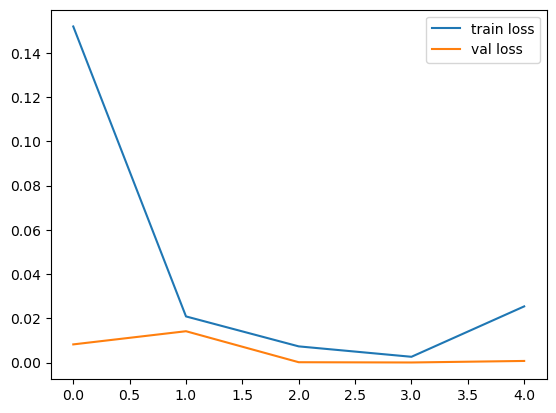

<Figure size 640x480 with 0 Axes>

In [24]:
# loss
plt.plot(history2.history['loss'], label='train loss')
plt.plot(history2.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

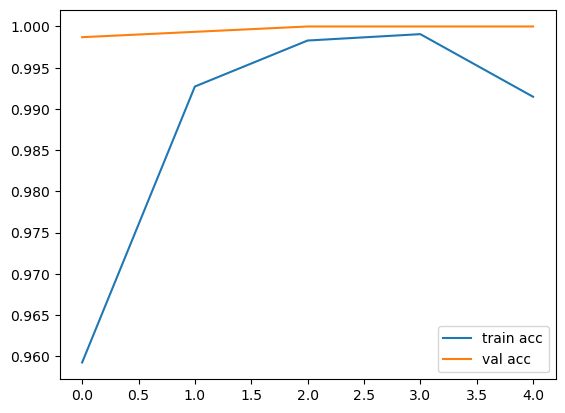

<Figure size 640x480 with 0 Axes>

In [25]:
# accuracies
plt.plot(history2.history['accuracy'], label='train acc')
plt.plot(history2.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

77/77 [==============================] - 115s 1s/step


<Figure size 800x600 with 0 Axes>

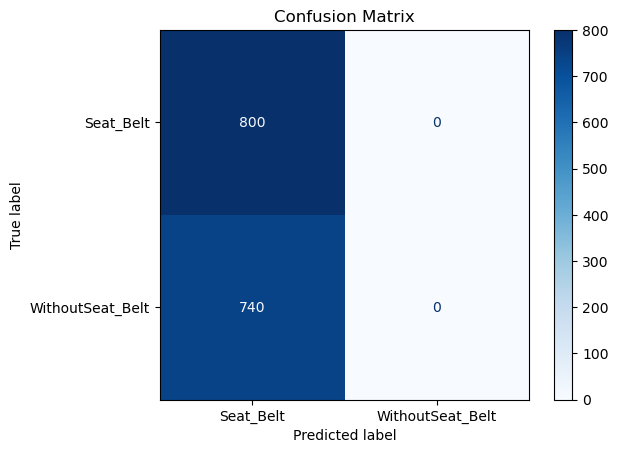

In [26]:
#confusion matrix
y_true = validation_generator.classes

y_pred = model.predict(validation_generator)
predicted_classes = np.argmax(y_pred, axis=1)

from sklearn import metrics
cm = metrics.confusion_matrix(y_true, predicted_classes)
plt.figure(figsize=(8, 6))
metrics.ConfusionMatrixDisplay(cm, display_labels=['Seat_Belt', 'WithoutSeat_Belt']).plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [27]:
#classification report
class_labels = list(validation_generator.class_indices.keys())
report = metrics.classification_report(y_true, predicted_classes, target_names=class_labels, zero_division=1)
print(report)

              precision    recall  f1-score   support

  noSeatbelt       0.52      1.00      0.68       800
    seatbelt       1.00      0.00      0.00       740

    accuracy                           0.52      1540
   macro avg       0.76      0.50      0.34      1540
weighted avg       0.75      0.52      0.36      1540



In [28]:
model.save('seatbelt_vs_noseatbelt.h5')

C:\Users\Khalil\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
